#Анализ популяции с применением метода кластеризации

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


df = pd.read_csv(
    ".//static//csv///world-population-by-country-2020.csv", index_col="no"
)

df["Population2020"] = df["Population2020"].apply(lambda x: int("".join(x.split(","))))
df["NetChange"] = df["NetChange"].apply(lambda x: int("".join(x.split(","))))
df["Yearly Change"] = df["Yearly Change"].apply(lambda x: float("".join(x.rstrip("%"))))
df["LandArea"] = df["LandArea"].apply(lambda x: int("".join(x.split(","))))
df["Density"] = df["Density"].apply(lambda x: int("".join(x.split(","))))

In [17]:
df.head()

Country (or dependency)  Population2020  Yearly Change  NetChange  Density  \
no                                                                              
1                    China      1439323776           0.39    5540090      153   
2                    India      1380004385           0.99   13586631      464   
3            United States       331002651           0.59    1937734       36   
4                Indonesia       273523615           1.07    2898047      151   
5                 Pakistan       220892340           2.00    4327022      287   

    LandArea Migrants (net) Fert. Rate Med. Age Urban Pop % World Share  
no                                                                       
1    9388211       -348,399        1.7       38         61%      18.47%  
2    2973190       -532,687        2.2       28         35%      17.70%  
3    9147420        954,806        1.8       38         83%       4.25%  
4    1811570        -98,955        2.3       30         56%       3.51%  
5     770880       -233,379        3.6       23         35%       2.83%

In [18]:
df.describe()

Population2020  Yearly Change     NetChange       Density      LandArea
count    2.350000e+02     235.000000  2.350000e+02    235.000000  2.350000e+02
mean     3.317120e+07       1.104298  3.461058e+05    478.408511  5.535918e+05
std      1.351370e+08       1.075665  1.128255e+06   2331.282424  1.687796e+06
min      8.010000e+02      -2.470000 -3.838400e+05      0.000000  0.000000e+00
25%      4.188015e+05       0.320000  4.240000e+02     37.000000  2.545000e+03
50%      5.459642e+06       0.970000  3.917000e+04     95.000000  7.724000e+04
75%      2.057705e+07       1.850000  2.496600e+05    240.000000  4.038200e+05
max      1.439324e+09       3.840000  1.358663e+07  26337.000000  1.637687e+07

In [19]:
# Процент пропущенных значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f'{i} Процент пустых значений: %{null_rate:.2f}')

print(df.isnull().sum())

print(df.isnull().any())

Migrants (net) Процент пустых значений: %14.47
Country (or dependency)     0
Population2020              0
Yearly Change               0
NetChange                   0
Density                     0
LandArea                    0
Migrants (net)             34
Fert. Rate                  0
Med. Age                    0
Urban Pop %                 0
World Share                 0
dtype: int64
Country (or dependency)    False
Population2020             False
Yearly Change              False
NetChange                  False
Density                    False
LandArea                   False
Migrants (net)              True
Fert. Rate                 False
Med. Age                   False
Urban Pop %                False
World Share                False
dtype: bool


In [20]:
# Проверка типов столбцов
df.dtypes

Country (or dependency)     object
Population2020               int64
Yearly Change              float64
NetChange                    int64
Density                      int64
LandArea                     int64
Migrants (net)              object
Fert. Rate                  object
Med. Age                    object
Urban Pop %                 object
World Share                 object
dtype: object


**Цель:** Кластеризация популяций стран для определения схожих характеристик.  


## Очистка данных

In [21]:
# Удалим несущественные столбцы
columns_to_drop = [
    "Migrants (net)",
    "Fert. Rate",
    "Med. Age",
    "Urban Pop %",
    "Country (or dependency)",
    "World Share",
]
df_cleaned = df.drop(columns=columns_to_drop)

print(df_cleaned.head())  # Вывод очищенного DataFrame

    Population2020  Yearly Change  NetChange  Density  LandArea
no                                                             
1       1439323776           0.39    5540090      153   9388211
2       1380004385           0.99   13586631      464   2973190
3        331002651           0.59    1937734       36   9147420
4        273523615           1.07    2898047      151   1811570
5        220892340           2.00    4327022      287    770880


## Визуализация парных взаимосвязей

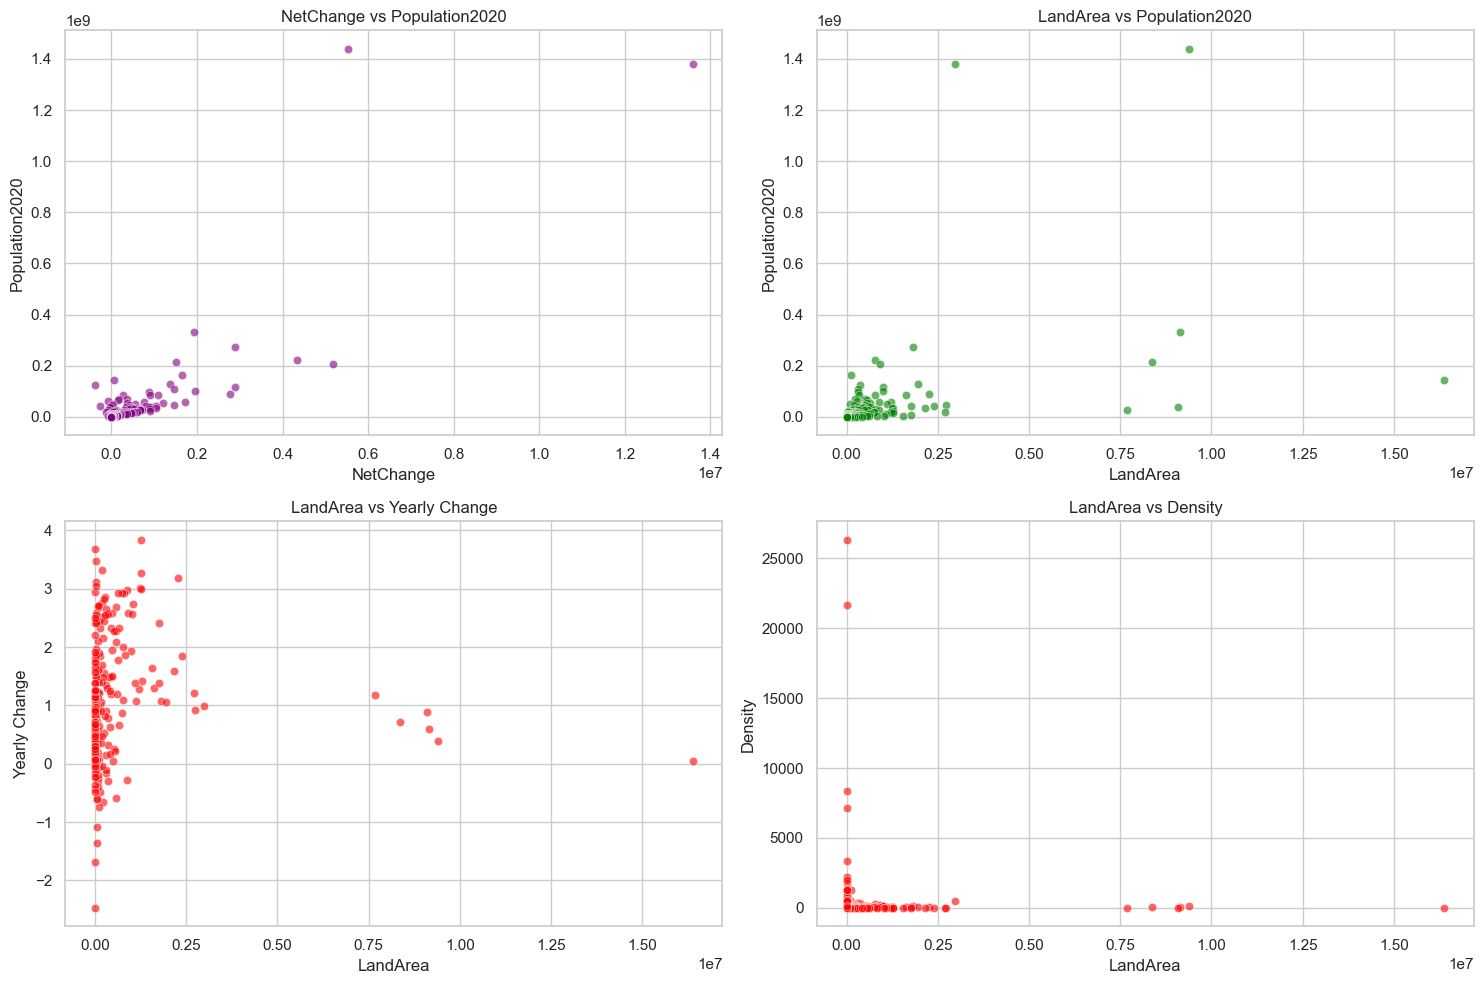

In [22]:
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание фигуры
plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned["NetChange"], y=df_cleaned["Population2020"], alpha=0.6, color="purple")
plt.title("NetChange vs Population2020")
plt.xlabel('NetChange')
plt.ylabel("Population2020")


plt.subplot(2, 2, 2)
sns.scatterplot(
    x=df_cleaned["LandArea"],
    y=df_cleaned["Population2020"],
    alpha=0.6,
    color="green",
)
plt.title("LandArea vs Population2020")
plt.xlabel("LandArea")
plt.ylabel("Population2020")

plt.subplot(2, 2, 3)
sns.scatterplot(
    x=df_cleaned["LandArea"], y=df_cleaned["Yearly Change"], alpha=0.6, color="red"
)
plt.title("LandArea vs Yearly Change")
plt.xlabel("LandArea")
plt.ylabel("Yearly Change")


plt.subplot(2, 2, 4)
sns.scatterplot(x=df_cleaned["LandArea"], y=df_cleaned["Density"], alpha=0.6, color="red")
plt.title("LandArea vs Density")
plt.xlabel("LandArea")
plt.ylabel("Density")


plt.tight_layout()
plt.show()

### Стандартизация данных для кластеризации

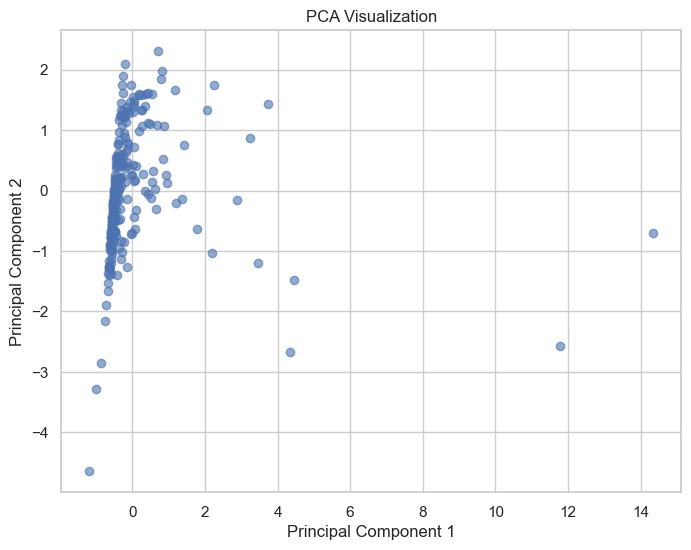

In [23]:
# Нормализация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned)

# Преобразование в DataFrame для удобства
df_scaled = pd.DataFrame(data_scaled, columns=df_cleaned.columns)

# Понижение размерности до 2 компонент
pca = PCA(n_components=2)
kc_pca = pca.fit_transform(df_scaled)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(kc_pca[:, 0], kc_pca[:, 1], alpha=0.6)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### Агломеративная (иерархическая) кластеризация

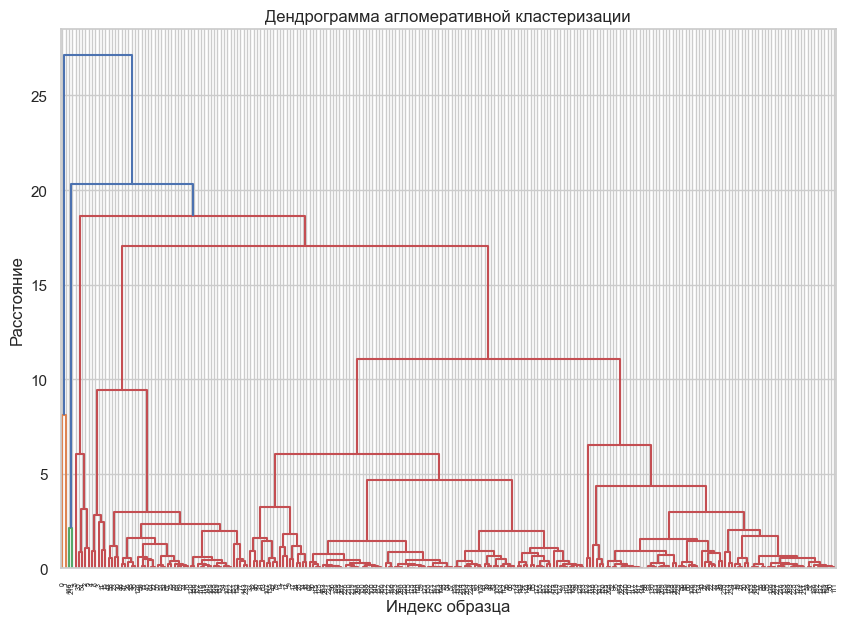

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [24]:
# Построение дендрограммы
linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

# Получение результатов кластеризации с заданным порогом
result = fcluster(linkage_matrix, t=60, criterion='distance')
print(result)  # Вывод результатов кластеризации

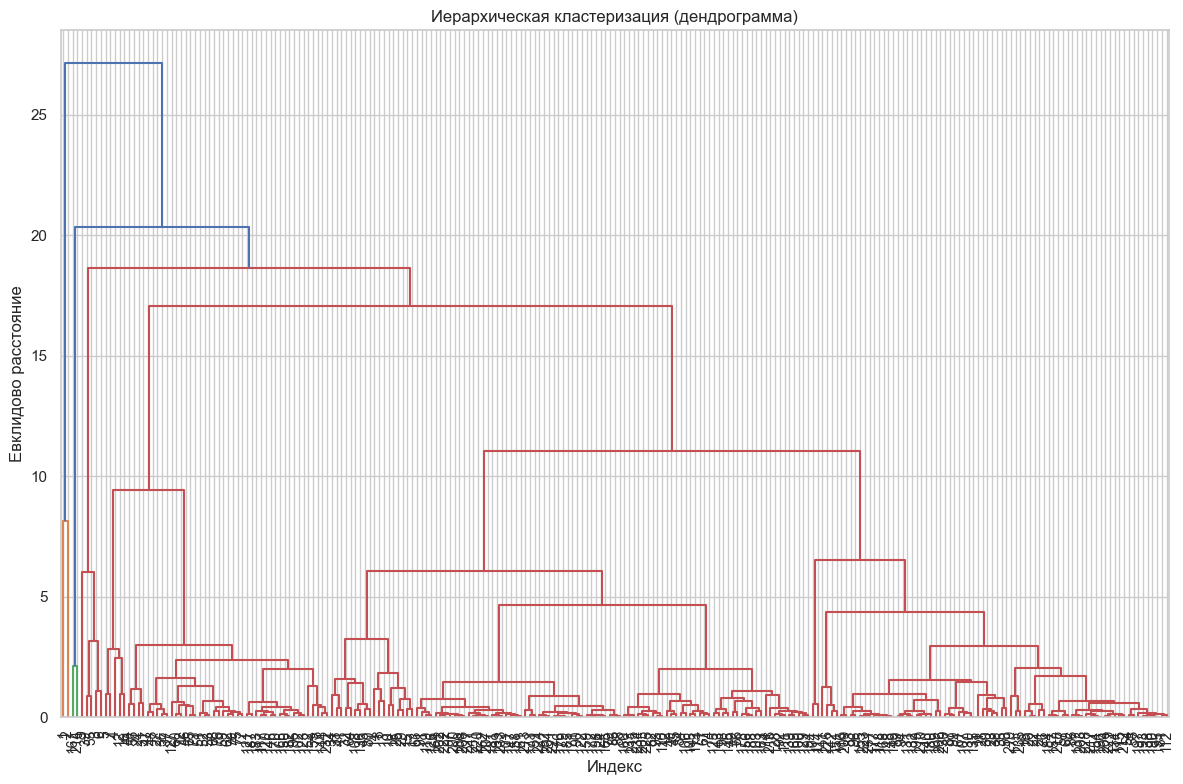

In [25]:
# Выбираем подмножество данных для кластеризации
features = df[["NetChange", "LandArea", "Density", "Yearly Change", "Population2020"]]

scaled_features = scaler.fit_transform(features)

# Построение дендрограммы
linkage_matrix = linkage(scaled_features, method='ward')  # Метод "Ward"

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Иерархическая кластеризация (дендрограмма)')
plt.xlabel('Индекс')
plt.ylabel('Евклидово расстояние')
plt.tight_layout()
plt.show()

**Визуализация распределения кластеров**

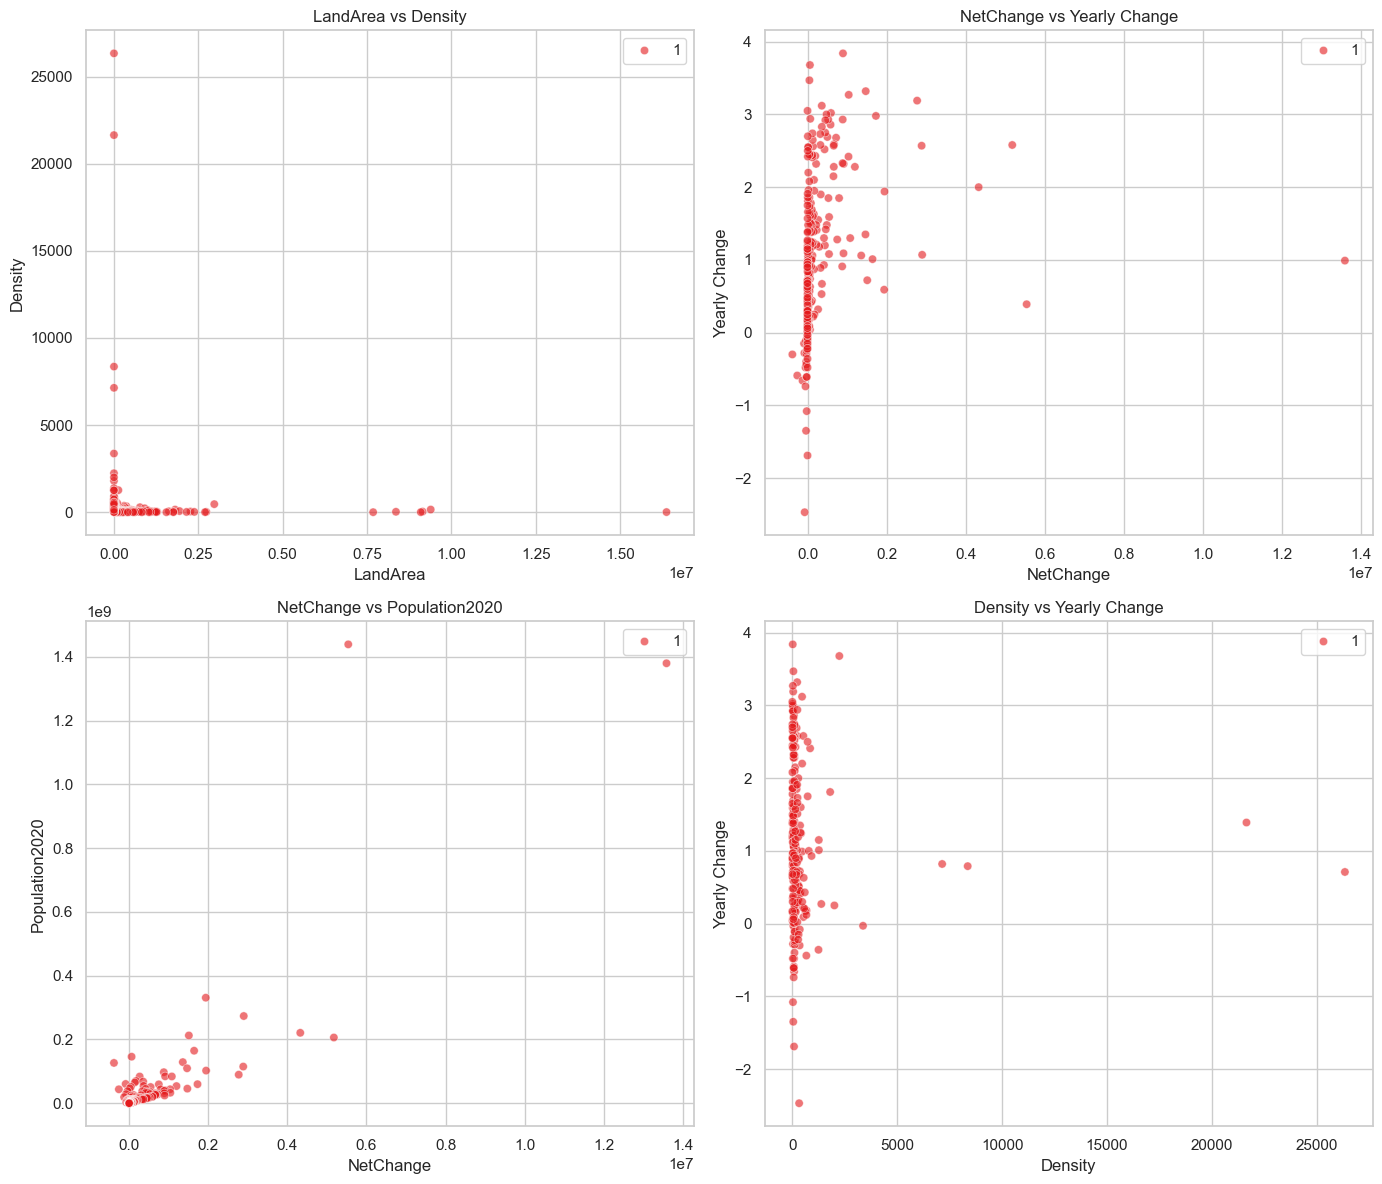

In [26]:
# Визуализация кластеров
plt.figure(figsize=(14, 12))


plt.subplot(2, 2, 1)
sns.scatterplot(
    x=df_cleaned["LandArea"],
    y=df_cleaned["Density"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("LandArea vs Density")
plt.xlabel("LandArea")
plt.ylabel("Density")


plt.subplot(2, 2, 2)
sns.scatterplot(
    x=df_cleaned["NetChange"],
    y=df_cleaned["Yearly Change"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("NetChange vs Yearly Change")
plt.xlabel("NetChange")
plt.ylabel("Yearly Change")

plt.subplot(2, 2, 3)
sns.scatterplot(
    x=df_cleaned["NetChange"],
    y=df_cleaned["Population2020"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("NetChange vs Population2020")
plt.xlabel("NetChange")
plt.ylabel("Population2020")


plt.subplot(2, 2, 4)
sns.scatterplot(
    x=df_cleaned["Density"],
    y=df_cleaned["Yearly Change"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("Density vs Yearly Change")
plt.xlabel("Density")
plt.ylabel("Yearly Change")

# Настройка графиков
plt.tight_layout()
plt.show()

## KMeans (неиерархическая кластеризация) для сравнения

d:\3_КУРС_ПИ\МИИ\aisenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\3_КУРС_ПИ\МИИ\aisenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\subprocess

Центры кластеров:
 [[2.65582879e+04 1.01425144e+05 3.61537879e+02 3.76969697e-01
  1.00728718e+07]
 [5.92861374e+05 1.05398517e+06 1.62666667e+02 2.08353535e+00
  3.68242102e+07]
 [9.56336050e+06 6.18070050e+06 3.08500000e+02 6.90000000e-01
  1.40966408e+09]
 [4.58400000e+03 1.55000000e+01 2.39910000e+04 1.05000000e+00
  3.44288500e+05]]


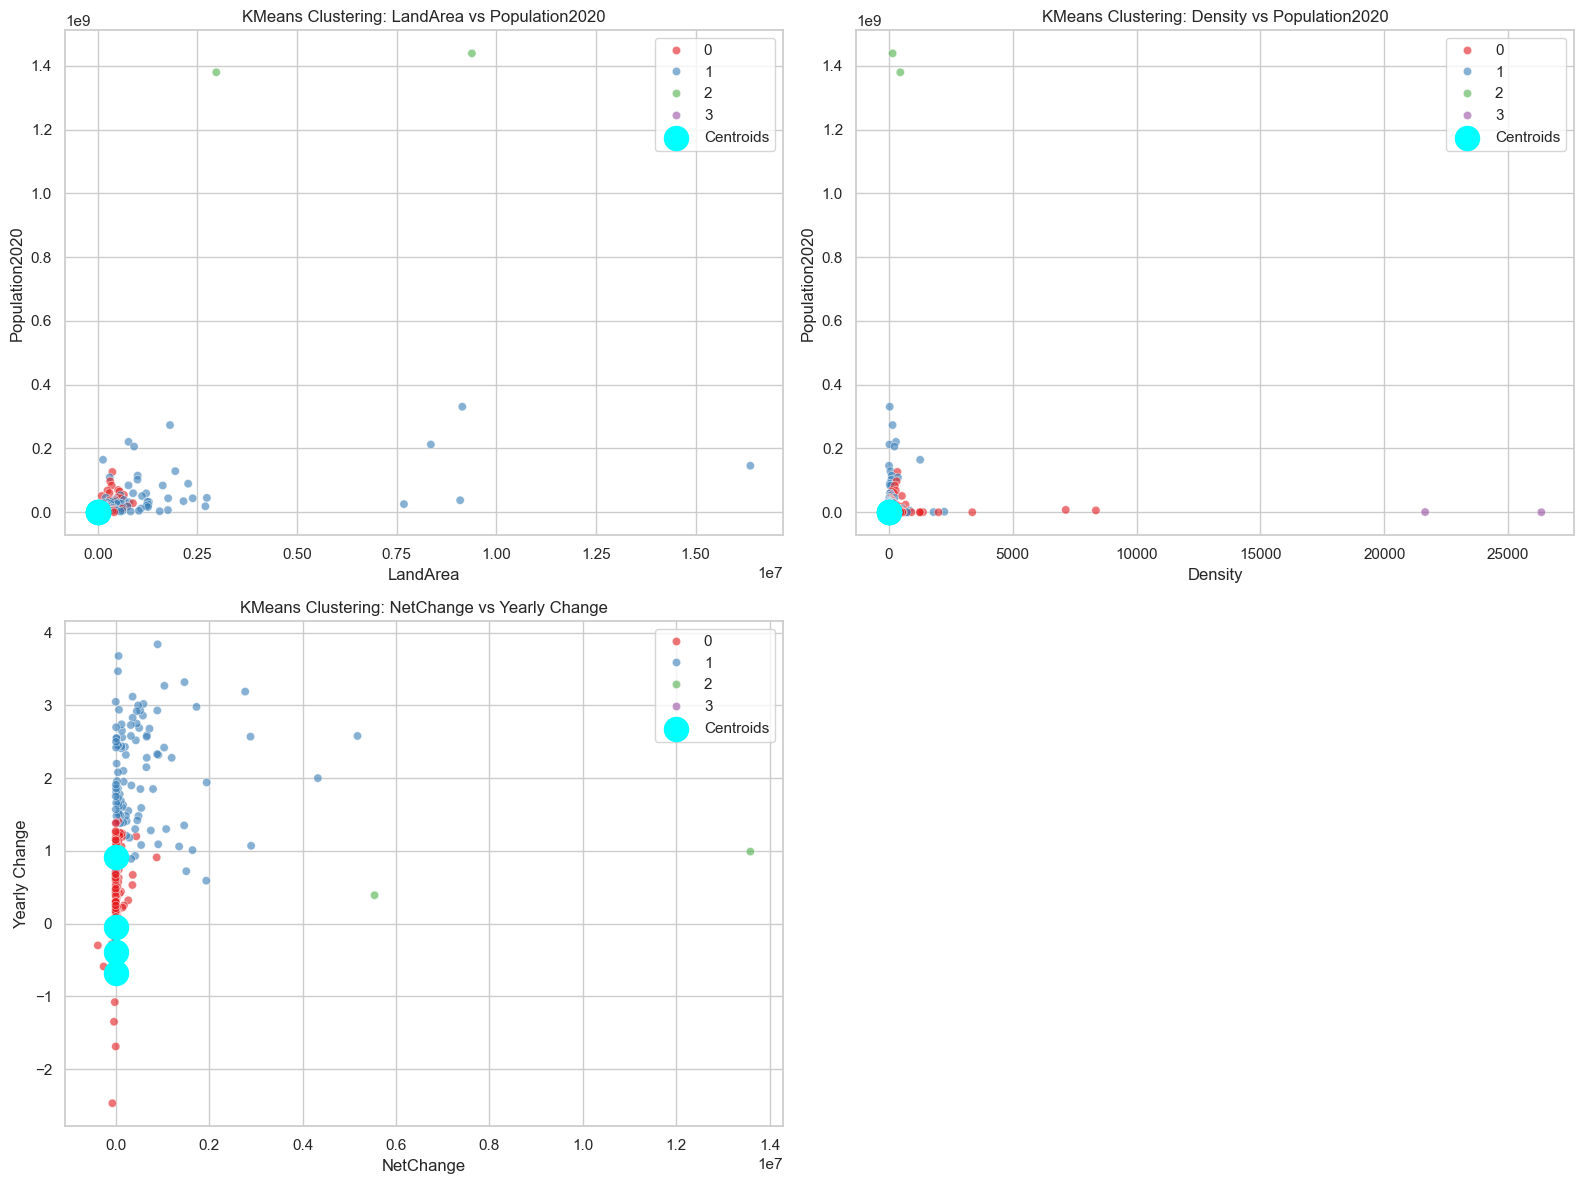

In [27]:
features_used = [
    'NetChange','LandArea','Density','Yearly Change','Population2020'
]
data_to_scale = df_cleaned[features_used]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_scale)

random_state = 42
kmeans = KMeans(n_clusters=4, random_state=random_state)
labels = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_

# Отображение центроидов
centers_original = scaler.inverse_transform(centers)  # Обратная стандартизация
print("Центры кластеров:\n", centers_original)

# Визуализация результатов кластеризации KMeans
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(
    x=df_cleaned["LandArea"],
    y=df_cleaned["Population2020"],
    hue=labels,
    palette="Set1",
    alpha=0.6,
)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='cyan', label='Centroids')
plt.title("KMeans Clustering: LandArea vs Population2020")
plt.legend()

plt.subplot(2, 2, 2)
sns.scatterplot(
    x=df_cleaned["Density"],
    y=df_cleaned["Population2020"],
    hue=labels,
    palette="Set1",
    alpha=0.6,
)
plt.scatter(centers[:, 2], centers[:, 3], s=300, c='cyan', label='Centroids')
plt.title("KMeans Clustering: Density vs Population2020")
plt.legend()

plt.subplot(2, 2, 3)
sns.scatterplot(
    x=df_cleaned["NetChange"],
    y=df_cleaned["Yearly Change"],
    hue=labels,
    palette="Set1",
    alpha=0.6,
)
plt.scatter(centers[:, 1], centers[:, 3], s=300, c='cyan', label='Centroids')
plt.title("KMeans Clustering: NetChange vs Yearly Change")
plt.legend()


plt.tight_layout()
plt.show()

### PCA для визуализации сокращенной размерности

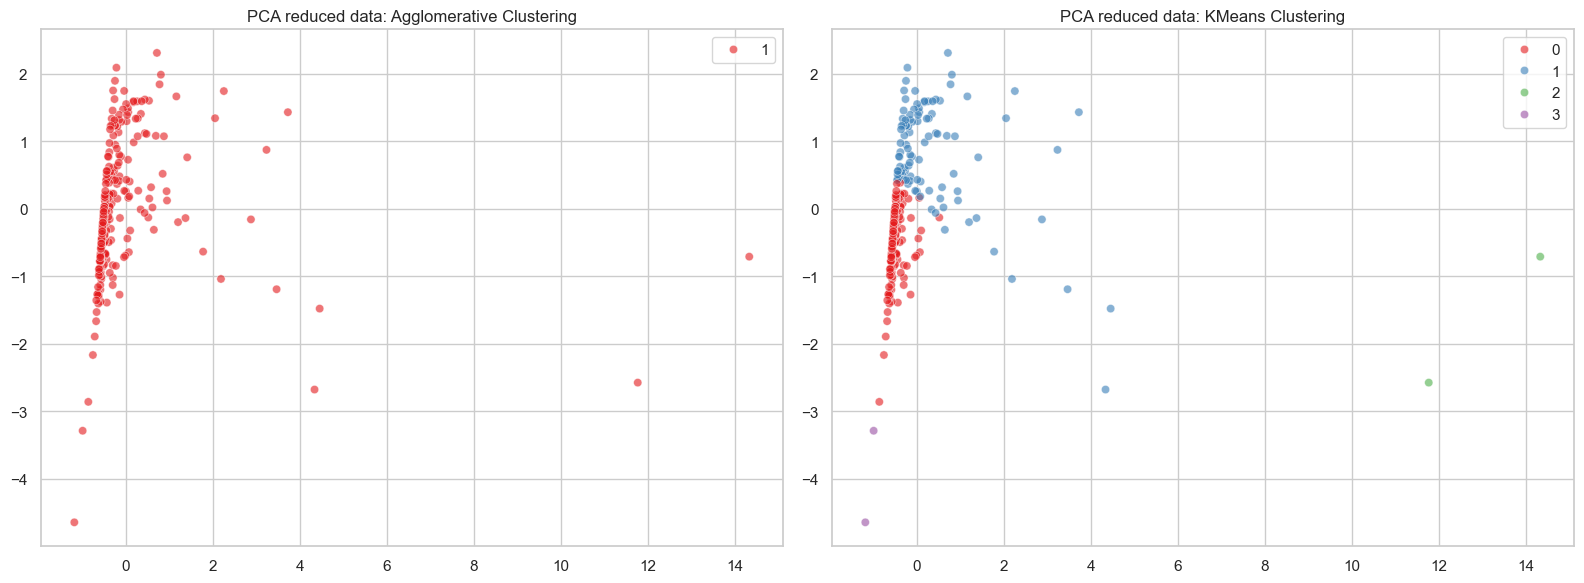

In [28]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация сокращенных данных
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=result, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: Agglomerative Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: KMeans Clustering')

plt.tight_layout()
plt.show()

### Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

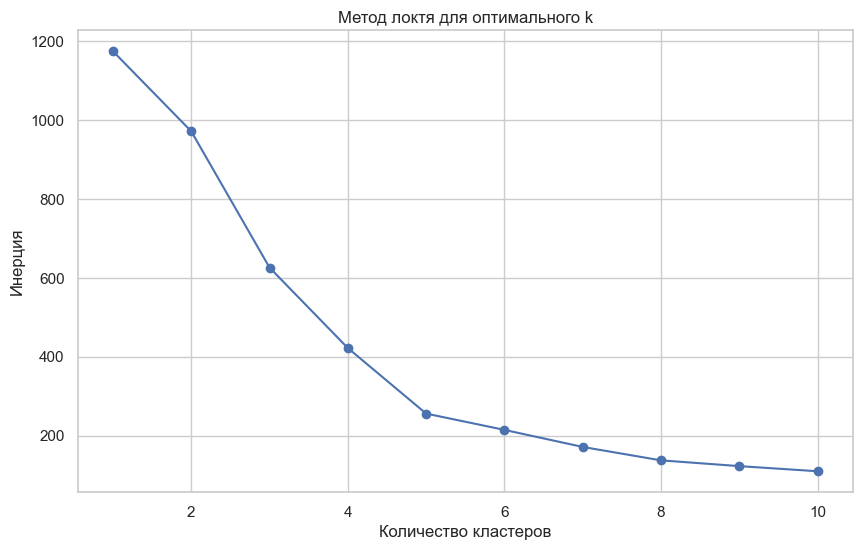

In [29]:
inertias = []
clusters_range = range(1, 11)
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

### Расчет коэффициентов силуэта

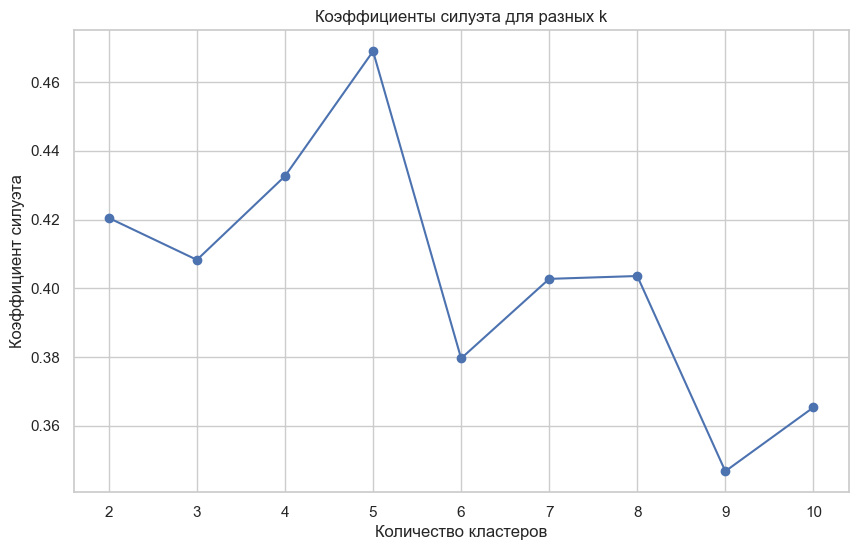

In [30]:
silhouette_scores = []
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта: 0.408


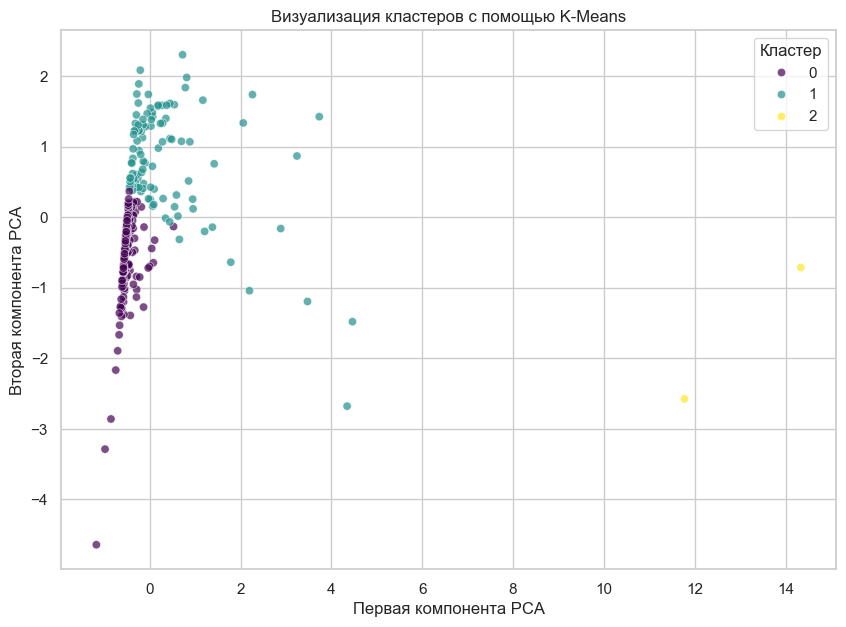

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# ========================
# Применение K-Means
# ========================
kmeans = KMeans(n_clusters=3, random_state=42)  
df_clusters = kmeans.fit_predict(df_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg = silhouette_score(df_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

# ========================
# Визуализация кластеров
# ========================
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Средний коэффициент силуэта, равный 0.408, указывает на умеренно хорошую кластеризацию.  

Средний коэффициент силуэта (silhouette score) указывает на качество кластеризации, измеряя, насколько хорошо точки внутри одного кластера близки друг к другу по сравнению с точками из других кластеров. Значения коэффициента силуэта находятся в диапазоне от -1 до 1:

1: Указывает на идеально плотные и четко разделенные кластеры.  
0: Указывает на перекрытие кластеров или слабую структуру кластеризации.  
Отрицательные значения: Указывают, что точки в кластере расположены ближе к другому кластеру, чем к своему.

Средний коэффициент силуэта (агломеративная кластеризация): 0.832


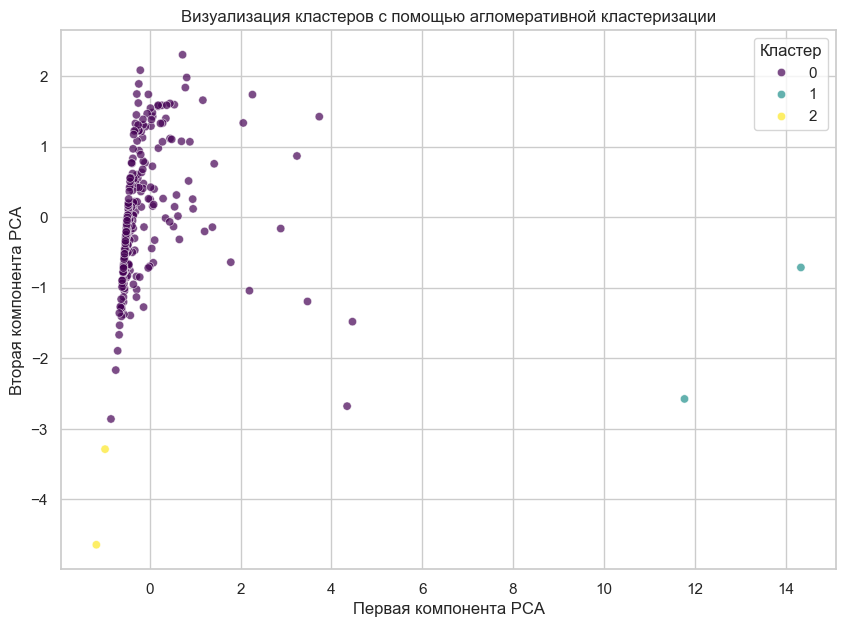

In [32]:
from sklearn.cluster import AgglomerativeClustering

# ========================
# Агломеративная кластеризация
# ========================
agg_cluster = AgglomerativeClustering(n_clusters=3)  
labels_agg = agg_cluster.fit_predict(df_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg_agg = silhouette_score(df_scaled, labels_agg)
print(f'Средний коэффициент силуэта (агломеративная кластеризация): {silhouette_avg_agg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=labels_agg, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью агломеративной кластеризации')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Значение коэффициента силуэта лежит в диапазоне от -1 до 1. Ближе к 1: Хорошо сформированные, плотные кластеры, четко отделенные друг от друга.  

Ближе к 0: Кластеры пересекаются или слабо разделены, не имеют четких границ. Точки расположены одинаково близко как к своему кластеру, так и к соседним. 
Ближе к -1 (Отрицательные значения): Некоторые точки скорее относятся к другим кластерам, чем к текущему (ближе к центрам других кластеров). Очень плохая кластеризация.  
Ближе к 1: Все точки внутри каждого кластера плотно сгруппированы и значительно удалены от точек других кластеров. Свидетельствует о четкой и хорошо разделенной структуре данных. Единица говорит об идеальной кластеризации.
